In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy as sp
import sys
import pylab
from scipy.optimize import fsolve


from bokeh.layouts import column,row,layout
from bokeh.models import ColumnDataSource, Slider, RadioButtonGroup,TableColumn, DataTable, Range1d, LinearAxis
from bokeh.plotting import figure, output_file, show
from bokeh.themes import Theme
from bokeh.io import show, output_notebook, output_file, push_notebook
from bokeh.layouts import widgetbox
from bokeh.models.tools import HoverTool, PointDrawTool

g = 9.81
pi = math.pi



sys.path.append('../')
import uPVT.PVT as PVT
import uSep.separation as sp
import uTemperature.uTemp as temp

output_notebook()


Result of separation check:
qgas_scm3day -work right
qo_scm3day -work right
unf_calc_natural_separation -work right
unf_calc_total_separation -work right
3


Loading BokehJS ...

In [2]:
class Save_temp_fluid_c(object):
    """
    Класс для сохранения значений температуры внутри функции
    temp_fluid, в которой решения выполняются итеративно
    с помощью fsolve()
    """

    def __init__(self, init):
        """
        Начальное значение температуры
        """
        self.temp_fluid_c = init

    def save(self, value):
        """
        Сохранение вычисленных значений T в класс
        """
        self.temp_fluid_c = value


class system_properties(object):
    """
    Класс для задания всех необходимых свойств для расчета КРТ
    """
    def __init__(self):
        # convective heat transfer in an Oil Well
        self.ql_m3sec = 79.5 / 86400
        self.qg_m3sec = 283 / 86400
        self.kl_wmc = 0.138
        self.kg_wmc = 1.73 * 10 ** (-4)
        self.rhol_kgm3 = 882.9
        self.rhog_kgm3 = 80.3
        self.cpl_jkgc = 2512
        self.cpg_jkgc = 2093
        self.mul_pas = 0.015
        self.mug_pas = 1.5 * 10 ** (-4)
        self.rti_m = 0.0259

        # natural convection in well annulus
        self.rto_m = 0.0561
        self.rci_m = 0.0797
        # parametres are medium
        self.mu_an_pas = 0.0001
        self.cp_an_jkgc = 1004.81
        self.rho_an_kgm3 = 36.92
        self.k_an_wmc = 0.865
        self.betta_1c = 0.004824
        self.delta_temp_an_c = 3

        # overall heat transfer coefficient
        self.rco_m = 0.0889
        self.rwb_m = 0.1079
        self.kcem_wmc = 0.779
        self.kt_wmc = 25
        self.ke_wmc = 2.422

        self.time_sec = 100 * 7 * 24 * 3600
        self.rhoe_kgm3 = 2504
        self.cpe_jkgc = 1256

        self.tei_c = 93.3
        self.distance_m = 1000
        self.gg_cm = 0.027
        self.gamma_gas = 0.65
        self.gamma_api = 29

        self.p_pa = 792.9 * 10 ** 3
        
        
        self.level_din_m = 1000
        self.m_cm = None #плотность внутренних источников теплоты
        self.cp_an_jkgc_array = None
        self.k_an_wmc_array = None 
        self.mu_an_pas_array = None
        self.rho_an_kgm3_array = None
        self.betta_1c_array = None 
        self.tfi_c = None

        #переменные, необходимые для реализации примеров
        '''self.pwh = 115
        self.mt_kgs = 1.07
        self.rp_sm3sm3 = 3.56'''
        
        #переменные для русской методики
        self.well_depth_m = 2550
        self.tetta_c = 11  # температура нейтрального слоя земли
        self.h_pump_m = 400 # высота подвеса насоса над забоем
        self.efficency_motor_perc = 70
        self.efficency_pump_perc = 40
        self.lenth_pump_m = 20 
        self.power_pump_v = 81 * 10**3
        self.lenth_motor_m = 15 


def_prop = system_properties()  # создание класса стандартный свойств


def q_motor_v(a_motor, d_motor_m, l_motor_m, t_wall_motor_c, tf_c):
    """
    Тепловой поток, выделяемый электродвигателем, передаваемый теплоотдачей обтекаемой скважинной продукции
    :param a_motor: коэффициент теплоотдачи от поверхности стенки э/д,
    :param d_motor_m: диаметр э/д, м
    :param l_motor_m: длина э/д, м
    :param t_wall_motor_c: температура стенок э/д, С
    :param tf_c: температура скважинной продукции, С
    :return: тепловой поток, Ватт
    """
    return a_motor * pi * d_motor_m * l_motor_m * (t_wall_motor_c - tf_c)


def t_wall_motor_c(tf_c, n_motor_v, efficiency_perc, a_motor, d_motor_m, l_motor_m):
    efficiency = efficiency_perc / 100
    return tf_c + n_motor_v * (1 - efficiency) / a_motor / pi / d_motor_m / l_motor_m


def de_m(dwb_m, ae_m2c, time_sec):
    """
    Диаметр окружающей ГП, соответствующей естесственной температуры
    :param dwb_m: диаметр скважины (цементного кольца), м
    :param ae_m2c: коэффициент температуропроводности ГП, м2 / сек
    :param time_sec: время прогрева, сек
    :return: диаметр возмущенной зоны, м
    """
    return dwb_m + 4 * math.sqrt(ae_m2c + time_sec)


def a_complex(dti_m, k_vm3c, gf_kgsec, cpf_jkgc):
    """
    Размерный комплекс А, учитывающий особенности теплообмена
    :param dti_m: внутренний диаметр трубы, где поднимается флюид, м ???
    :param k_vm3c: коэффициент теплопередачи от добываемого флюида в ГП, Ватт / м2 / С
    :param gf_kgsec: массовый расход флюида, кг / сек
    :param cpf_jkgc: теплоемкость флюида, Дж / кг / С
    :return: А, 1/м
    """
    return pi * dti_m * k_vm3c / gf_kgsec / cpf_jkgc


def m_complex(ql_vm, gf_kgsec, cpf_jkgc):
    """
    Размерный комплекс м, учитывающий особенности теплообмена
    :param ql_vm: линейная плотность внутренних источников (+) и стоков (-) теплоты, Вт / м
    :param gf_kgsec: массовый расход флюида, кг / сек
    :param cpf_jkgc: теплоемкость флюида, Дж / кг / С
    :return: m, К / м
    """
    return ql_vm / gf_kgsec / cpf_jkgc


def tf_along_pump(x, t1_c, tetta, gg_cm, a_pump_1m, h_pump_m, m_km):
    zero_part = tetta
    first_part = gg_cm / a_pump_1m * ( - np.exp(-a_pump_1m * x) + 1)
    second_part = (t1_c - tetta) * np.exp(-a_pump_1m * x)
    second_part_2 = (t1_c) * np.exp(-a_pump_1m * x)
    third_part =  - gg_cm * (h_pump_m * (np.exp(-a_pump_1m * x) - 1)  + x) 
    fourth_part = m_km / a_pump_1m * (1 - np.exp(-a_pump_1m * x))
    return zero_part + first_part  + second_part + third_part + fourth_part


def tf_along_pump_exp(x, t1_c, tetta, gg_cm, a_pump_1m, h_pump_m, m_km):
    zero_part = tetta
    first_part = gg_cm / a_pump_1m * ( - np.exp(-a_pump_1m * x) + 1)
    second_part = (t1_c - tetta) * np.exp(-a_pump_1m * x)
    second_part_2 = (t1_c) * np.exp(-a_pump_1m * x)
    third_part =  - gg_cm * (h_pump_m * (np.exp(-a_pump_1m * x) - 1)  + x) 
    fourth_part = m_km / a_pump_1m * (1 - np.exp(-a_pump_1m * x))
    #return zero_part + first_part  + second_part + third_part + fourth_part
    return [first_part*0+zero_part,first_part,second_part,third_part,fourth_part]
    #return  first_part  + second_part_2 + third_part + fourth_part
    

In [3]:
x = np.arange(0, 20, 1)
all_prop = system_properties()

Применение расчетных формул

In [4]:
var_k_vm3c = 6
var_ql_pump_vm = (all_prop.power_pump_v * all_prop.efficency_motor_perc * 
                  all_prop.efficency_pump_perc / 10000 / all_prop.lenth_motor_m)
var_gf_kgsec = all_prop.ql_m3sec * all_prop.rhol_kgm3

var_m_complex = m_complex(var_ql_pump_vm, var_gf_kgsec, all_prop.cpl_jkgc)

var_a_complex = a_complex(all_prop.rti_m *2, var_k_vm3c, var_gf_kgsec, all_prop.cpl_jkgc)

t1_c = 80 

distribution_tf_c = tf_along_pump(x, t1_c, all_prop.tetta_c, 
                                  all_prop.gg_cm, var_a_complex, all_prop.h_pump_m, var_m_complex)

distribution_tf_c_var2 = tf_along_pump(x, t1_c, 0, 
                                  all_prop.gg_cm, var_a_complex, all_prop.h_pump_m, var_m_complex)




Анализ составных частей уравнения для насоса

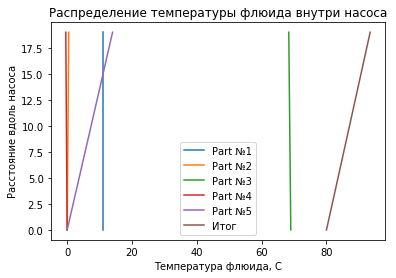

In [5]:
all_prop = system_properties()
distribution_tf_c_exp = tf_along_pump_exp(x, t1_c, all_prop.tetta_c, 
                                  all_prop.gg_cm, var_a_complex, all_prop.h_pump_m, var_m_complex)
labels=[]
k=0
for i in distribution_tf_c_exp:
    k+=1
    y = i
    plt.plot(y,x)    
    plt.title('Распределение температуры флюида внутри насоса')
    labels.append('Part №'+str(k))
    plt.xlabel('Температура флюида, С')
    plt.ylabel('Расстояние вдоль насоса')

    
distribution_tf_c = tf_along_pump(x, t1_c, all_prop.tetta_c, 
                                  all_prop.gg_cm, var_a_complex, all_prop.h_pump_m, var_m_complex)

plt.plot(distribution_tf_c,x)
labels.append('Итог')
plt.legend(labels)
plt.show()    

Влияние параметра Тетта - температура (жидкости) нейтрального слоя

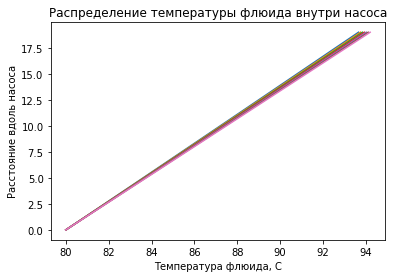

In [6]:
for i in range(30,100,10):
    all_prop.tetta_c=i
    distribution_tf_c = tf_along_pump(x, t1_c, all_prop.tetta_c, 
                                  all_prop.gg_cm, var_a_complex, all_prop.h_pump_m, var_m_complex)
    plt.plot(distribution_tf_c,x)
    
    plt.title('Распределение температуры флюида внутри насоса')
    plt.xlabel('Температура флюида, С')
    plt.ylabel('Расстояние вдоль насоса')
plt.show()

Влияние отсутсвия тетта

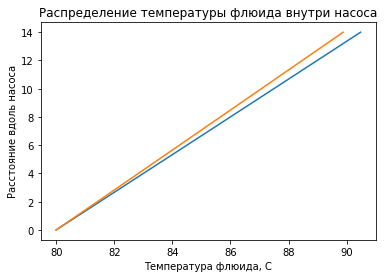

In [7]:
distribution_tf_c = tf_along_pump(x, t1_c, all_prop.tetta_c, 
                                  all_prop.gg_cm, var_a_complex, all_prop.h_pump_m, var_m_complex)

distribution_tf_c_var2 = tf_along_pump(x, t1_c, 0, 
                                  all_prop.gg_cm, var_a_complex, all_prop.h_pump_m, var_m_complex)

plt.plot(distribution_tf_c[0:15],x[0:15])
plt.plot(distribution_tf_c_var2[0:15],x[0:15])
plt.title('Распределение температуры флюида внутри насоса')
plt.xlabel('Температура флюида, С')
plt.ylabel('Расстояние вдоль насоса')
plt.show()

In [8]:
import math
from scipy.optimize import fsolve
import numpy as np

g = 9.81
pi = math.pi


class Save_temp_fluid_c(object):
    """
    Класс для сохранения значений температуры внутри функции
    temp_fluid, в которой решения выполняются итеративно
    с помощью fsolve()
    """

    def __init__(self, init):
        """
        Начальное значение температуры
        """
        self.temp_fluid_c = init

    def save(self, value):
        """
        Сохранение вычисленных значений T в класс
        """
        self.temp_fluid_c = value




def_prop = system_properties()  # создание класса стандартный свойств


def fc_var2(p_pa, mt_kgs, rp_sm3sm3, gamma_api, gamma_gas, gg_cm):
    """
    Корреляция Sagar et al. (1991) для расчетра Fc
    физически - совокупность влияния эффекта Джоуля-Томпсона и
    изменения кинетической энергии на теплоперенос
    p_pa - давление, Па
    mt_kgs - массовый расход, кг/с
    rp_sm3sm3 - газовый фактор, м3/м3 ???
    gamma_api - плотность нефти, АPI
    gamma_gas - относительная плотность газа (по воздуху???)
    gg_cm - геотермический градиент, градус Цельсия на м 
	out -  градус Цельсия на м 
	Расчет в несистемных размерностях, выход в СИ
	Пример:
	import uTemperature.uTemp as temp
	sys_prop=temp.system_properties()
	result=temp.fc_var2(sys_prop.p_pa,sys_prop.mt_kgs,sys_prop.rp_sm3sm3,
           sys_prop.gamma_api,sys_prop.gamma_gas,sys_prop.gg_cm)
	"""
    # Перевод размерностей
    p_psi = p_pa / 6894.757293178
    gg_fft = gg_cm / 1.82268883056
    rp_scfstb = rp_sm3sm3 / 0.17810760667903497
    mt_lbms = mt_kgs * 2.2046226218487757

    result_fft = ((-2.978) * 10 ** (-3) + 1.006 * 10 ** (-6) * p_psi + 1.906 * 10 ** (-4) * mt_lbms - 1.047 * 10 ** (
        -6) * rp_scfstb +
                  3.229 * 10 ** (-5) * gamma_api + 4.009 * 10 ** (-3) * gamma_gas - 0.3551 * gg_fft)
    return result_fft * 1.82268883056


def number_gr(rho, betta, delta_t, d, mu):
    """
    Рассчет числа Грасгофа
    :param rho: Плотность, кг / м3
    :param betta:  Коэффициент объемного температурного расширения флюида, 1 / С
    :param delta_t: Разница температур, С
    :param d: Диаметр, м
    :param mu: Вязкость, Па * с
    :return: Число Грасгофа, безразмерное
    """
    return rho**2*betta*g*delta_t*d**3/mu**2


def number_pr(cp, mu, k):
    """
    Рассчет числа Прандтля
    :param cp: Теплоемкость,  Дж / кг / С
    :param mu: Вязкость, Па * с
    :param k: Коэффициент теплопроводности, Ватт / м / С
    :return: Число Прандтля, безразмерное
    """
    return cp*mu/k


def number_nu(h, d, k):
    """
    Рассчет числа Нуссельта
    :param h: коэффициент теплоотдачи,  Ватт / м2 / С
    :param d: диаметр, м
    :param k: коэффициент теплопроводности, Ватт / м / С
    :return: Число Нуссельта, безразмерное
    """
    return h*d/k


def number_re(rho, v, d, mu):
    """
    Число Рейнольдса
    :param rho: Плотность, кг / м3
    :param v: Скорость, м / с
    :param d: Диаметр, м
    :param mu:  Вязкость, Па * с
    :return: Число Рейнольдса, безразмерное
    """
    return rho*v*d/mu


def number_nu_corr(n_re, n_pr):
    """
    Корреляция для рассчета числа Нуссельта
    :param n_re: Число Рейнольдса
    :param n_pr: Число Прандтля
    :return: Число Нуссельта
    """
    return 0.023*n_re**0.8*n_pr**0.3


def han_var2(mu_an_pas, cp_an_jkgc, k_an_wmc, delta_temp_an_c, rho_an_kgm3, betta_1c, rci_m, rto_m):
    """
    Функция для расчета коэффициента теплоотдачи при есстественной конвекции в затрубном пространстве
    :param mu_an_pas: Вязкость флюида в затрубном пространстве, Па * с
    :param cp_an_jkgc: Теплоекость флюида в затрубном пространстве, Дж / кг / С
    :param k_an_wmc: Коэффициент теплопроводности в затрубном пространстве, Ватт / м / С
    :param delta_temp_an_c: Разница температур в затрубном пространстве, С
    :param rho_an_kgm3: Плотность флюида в затрубном пространстве, кг / м3
    :param betta_1c: Коэффициент объемного температурного расширения флюида в з.п., 1 / С
    :param rci_m: Внутренний диаметр обсадной колонны, м
    :param rto_m: Внешний диаметр НКТ
    :return: Коэффициент теплоотдачи, Ватт / м2 / С
    Пример:
    example_han_var2=temp.han_var2(sys_prop.mu_an_pas, sys_prop.cp_an_jkgc,
                              sys_prop.k_an_wmc, sys_prop.delta_temp_an_c,
                              sys_prop.rho_an_km3, sys_prop.betta_1c,
                              sys_prop.rci_m, sys_prop.rto_m)
    """
    npr = number_pr(cp_an_jkgc, mu_an_pas, k_an_wmc)
    ngr = number_gr(rho_an_kgm3, betta_1c, delta_temp_an_c, (rci_m - rto_m), mu_an_pas)
    han = 0.049 * (ngr * npr) ** (1 / 3) * npr ** 0.074 * k_an_wmc / (rto_m * math.log(rci_m / rto_m))
    han = 0.25 * han
    return han


def hf(ql_m3sec, qg_m3sec, rhol_kgm3, rhog_kgm3,
       mul_pas, mug_pas, kl_wmc, kg_wmc,
       cpl_jkgc, cpg_jkgc, rti_m):
    """
    Рассчет коэффициента конвективной теплоотдачи в НКТ
    :param ql_m3sec: расход жидкости, м3 / сек
    :param qg_m3sec: расход газа, м3 / сек
    :param rhol_kgm3: плотность жидкости, кг / м3
    :param rhog_kgm3: плотность газа, кг / м3
    :param mul_pas: вязкость жидкости, Па * с
    :param mug_pas: вязкость газа, Па * с
    :param kl_wmc: коэффициент теплопроводности жидкости, Ватт  / м / С
    :param kg_wmc: коэффициент теплопроводности газа,  Ватт  / м / С
    :param cpl_jkgc: теплоемкость жидкости, Дж  / кг / с
    :param cpg_jkgc: теплоемкость газа, Дж  / кг / с
    :param rti_m: внутренний диаметр НКТ, м
    :return: Коэффициент конвективной теплоотдачи, Ватт / м2 / С
    """
    d = rti_m * 2
    ap = pi/4*d**2
    vsl = ql_m3sec/ap
    vsg = qg_m3sec/ap
    vm = vsl+vsg
    llambda = vsl/vm
    rhon = rhol_kgm3*llambda+rhog_kgm3*(1-llambda)
    mun = mul_pas*llambda+mug_pas*(1-llambda)
    kn = kl_wmc*llambda+kg_wmc*(1-llambda)
    cpn = (cpl_jkgc*rhol_kgm3*llambda+cpg_jkgc*rhog_kgm3*(1-llambda))/rhon
    nren = number_re(rhon, vm, d, mun)
    nprn = number_pr(cpn, mun, kn)
    nnu = number_nu_corr(nren, nprn)
    return nnu*kn/d


def td(time_sec, ke_wmc, rhoe_kgm3, cpe_jkgc, rwb_m):
    """
    Рассчет безразмерного времени
    :param time_sec: время с начала работы скважины, сек
    :param ke_wmc: коэффициент теплопроводности горных пород,  Ватт / м / С
    :param rhoe_kgm3: плотность горных пород, кг / м3
    :param cpe_jkgc: теплоемкость горных пород, Дж / кг / С
    :param rwb_m: радиус скважины, м (внешний радиус цементного кольца
    :return: безразмерное время
    """
    result = ke_wmc*time_sec/(rhoe_kgm3*cpe_jkgc*(math.pow(rwb_m, 2)))
    return result


def tempd(td):
    """
    Безразмерная температура или f(c)
    :param td: безразмерное время
    :return: бехразмерная температура
    """
    if td <= 1.5:
        return 1.1281 * math.sqrt(td) * (1 - 0.3 * math.sqrt(td))
    elif td > 1.5:
        return (0.4063 + 1 / 2 * math.log(td)) * (1 + 0.6 / td)


def temp_fluid_c(rhon, vm, at,
                 cpm, u, rto_m,
                 fc, tei_c, gg_cm, distance_m,m_cm,tfi_c):
    """
    Расчет температуры флюида в НКТ
    :param rhon: средняя плотность флюида, кг / м3
    :param vm: средняя скорость флюида без учета скольжения газа, м / с , (vsl+vsg)
    :param at: внутреннее сечение НКТ, м2
    :param cpm: средняя теплоемкость флюида,  Дж / кг / С
    :param u: общий коэффициент теплопередачи, Ватт / м2 / м
    :param rto_m: внешний диаметр НКТ, м
    :param fc: безразмерная функция
    :param tei_c: начальная температура окружающей среды, пласта, на забое, С
    :param gg_cm: геотермический градиент, С / м
    :param distance_m: расстояние от забоя до точки исследования, м
    :return: Температура флюида в НКТ, С
    """
    dto_m = rto_m*2
    mt = rhon*vm*at
    a = mt*cpm/pi/dto_m/u
    return ((tei_c-gg_cm*distance_m)+ (tfi_c - tei_c)*np.exp(-distance_m/a) +
            a*(1-np.exp(-distance_m/a))*(gg_cm-g/cpm+fc+m_cm))


def uto(hf, han, tempd, rti_m,
        rto_m, rco_m, rci_m,
        rwb_m, ke_wmc, kcem_wmc, kt_wmc):
    """
    Общий коэффициент теплопередачи, состоящий из нескольких частей
    :param hf: конвективный коэффициет теплоотдачи в НКТ, Ватт / м2 / С
    :param han: конвективный коэффициет теплоотдачи в затрубном пространстве, Ватт / м2 / С
    :param tempd: безразмерная температура или f(t)
    :param rti_m: внутренний диаметр НКТ, м
    :param rto_m: внешний радиус НКТ, м
    :param rco_m: внешний радиус обсадной колонны, м
    :param rci_m: внутренний радиус обсадной колонны, м
    :param rwb_m: внешний радиус скважины (внешний радиус цементного кольца), м
    :param ke_wmc: коэффициент теплопроводности ГП, Ватт / м / С
    :param kcem_wmc: коэффициент цементного кольца, Ватт / м / С
    :param kt_wmc: коэффициент теплопроводности металла труб (НКТ и ОК), Ватт / м / С
    :return: Общий коэффициент теплопередачи, Ватт / м2 / С
    """
    first_part = 1/rti_m/hf   # теплоотдача от ж к внутренней стенки НКТ
    second_part = math.log(rto_m/rti_m)/kt_wmc/2    # убрать 2- ошибка #теплопередача через стенку НКТ
    third_part = 1/rci_m/han    # конвекция через затруб
    fourth_part = math.log(rco_m/rci_m)/kt_wmc/2     # убрать 2- ошибка #теплопередача через стенку ОК
    fifth_part = math.log(rwb_m/rco_m)/kcem_wmc    # теплопередача через цементное кольцо
    sixth_part = tempd/ke_wmc    # теплопередача через цементное кольцо

    return 1/(first_part+second_part+third_part+fourth_part+fifth_part+sixth_part)/rto_m


def temp_diff_an(tr_c, gg_cm, distance_m,
                 rto_m, u, tf_c,
                 rti_m, han):
    """
    Разница температур в затрубном пространстве
    :param tr_c: температура пласта на забое, С
    :param gg_cm: геотермический градиент, С / м
    :param distance_m: расстояние от забоя, м
    :param rto_m: внешний радиус НКТ, м
    :param u: общий коэффициент теплопередачи, Ватт / м2 / С
    :param tf_c: температура флюида в НКТ, С
    :param rti_m: внутренний радиус НКТ, м
    :param han: коэффициент конвективной теплоотдачи в затрубном пространстве, Ватт / м2 / С
    :return: Разница температур в затрубном пространстве, С
    """
    tg_c = tr_c-distance_m*gg_cm  # температура ГП на distance_m от забоя
    q = 2*pi*rto_m*u*(tf_c-tg_c)  # тепловой поток
    temp_diff_an = q/(2*pi*rti_m*han)
    return temp_diff_an




def temp_fluid(distance_m, p_pa, delta0=1, data=def_prop):
    """
    Итоговая функция для для расчета температуры.
    На вход может подаваться numpy - матрица
    :param distance_m: расстояние от забоя, м
    :param p_pa:  давление, Па
    :param delta0: начальное приближение перепада температур в затрубном пространестве
                    для расчета функцией fsolve
    :param data: экземляр класса system_properties, со всеми необходимыми данными,
                    по умолчанию данные с примера
    :return: температура в данной точке или numpy матрица КРТ
    """
    data_temp = Save_temp_fluid_c(None)  # экземляр класса для хранения вычисленных данных


    def temp_diff_an_iter(delta):
        ap = pi / 4 * (data.rti_m * 2) ** 2
        vsl = data.ql_m3sec / ap
        vsg = data.qg_m3sec / ap
        vm = vsl + vsg
        llambda = vsl / vm
        rhon = data.rhol_kgm3 * llambda + data.rhog_kgm3 * (1 - llambda)
        mun = data.mul_pas * llambda + data.mug_pas * (1 - llambda)
        kn = data.kl_wmc * llambda + data.kg_wmc * (1 - llambda)
        cpn = ((data.cpl_jkgc * data.rhol_kgm3 * llambda + data.cpg_jkgc *
                data.rhog_kgm3 * (1 - llambda)) / rhon)

        rp = data.qg_m3sec / data.ql_m3sec
        mt = rhon * vm * ap

        val_hf = hf(data.ql_m3sec, data.qg_m3sec, data.rhol_kgm3, data.rhog_kgm3,
                    data.mul_pas, data.mug_pas, data.kl_wmc,
                    data.kg_wmc, data.cpl_jkgc, data.cpg_jkgc,
                    data.rti_m)
        val_han = han_var2(data.mu_an_pas, data.cp_an_jkgc, data.k_an_wmc,
                          delta, data.rho_an_kgm3,
                         data.betta_1c, data.rci_m, data.rto_m)
        #val_han = han_var2(data.mu_an_pas_array, data.cp_an_jkgc_array, data.k_an_wmc_array,
        #                  delta, data.rho_an_kgm3_array,
        #                   data.betta_1c_array, data.rci_m, data.rto_m)
        val_td = td(data.time_sec, data.ke_wmc, data.rhoe_kgm3,
                    data.cpe_jkgc, data.rwb_m)
        val_tempd = tempd(val_td)
        val_uto = uto(val_hf, val_han, val_tempd,
                      data.rti_m, data.rto_m, data.rco_m,
                      data.rci_m, data.rwb_m, data.ke_wmc,
                      data.kcem_wmc, data.kt_wmc)
        val_fc = fc_var2(p_pa, mt, rp, data.gamma_api, data.gamma_gas, data.gg_cm)
        val_temp_fluid_c = temp_fluid_c(rhon, vm, ap, cpn, val_uto,
                                        data.rto_m, val_fc,
                                        data.tei_c, data.gg_cm,
                                        distance_m,data.m_cm, data.tfi_c)
        data_temp.save(val_temp_fluid_c)  # сохранения в экземляр значений температуры
        val_temp_diff_an = temp_diff_an(data.tei_c, data.gg_cm, distance_m,
                                        data.rto_m, val_uto, val_temp_fluid_c,
                                        data.rti_m, val_han)
        result = val_temp_diff_an - delta
        return result


    delta = fsolve(temp_diff_an_iter, delta0)

    return data_temp.temp_fluid_c


print(3)


3


In [9]:
sys_prop=system_properties()
depth_m = 2550
pbh_pa=25*10**6
c=pbh_pa/depth_m
tei=sys_prop.tei_c
gg=sys_prop.gg_cm
tff, tfg, p=[], [], []

for i in range(1,depth_m,1):
    p_val=pbh_pa-c*i
    tg=tei-gg*i
    tfg.append(tg)
    p.append(p_val)
l=np.asarray(list(range(1,depth_m,1)))
p=np.asarray(p)
tfg=np.asarray(tfg)
mistake=p*0+1
#sys_prop=system_properties()
betta_oil_1c = 0.000831
border = 2550 - sys_prop.level_din_m 
array_betta = p.copy()
array_betta[0:border]=betta_oil_1c
array_betta[border::]=sys_prop.betta_1c

array_mu = p.copy()
array_mu[0:border]=sys_prop.mul_pas
array_mu[border::]=sys_prop.mu_an_pas

array_cp = p.copy()
array_cp[0:border]=sys_prop.cpl_jkgc
array_cp[border::]=sys_prop.cp_an_jkgc

array_rho = p.copy()
array_rho[0:border]=sys_prop.rhol_kgm3
array_rho[border::]=sys_prop.rho_an_kgm3

array_k = p.copy()
array_k[0:border]=sys_prop.kl_wmc
array_k[border::]=sys_prop.kg_wmc



sys_prop.betta_1c_array = array_betta
sys_prop.cp_an_jkgc_array = array_cp
sys_prop.k_an_wmc_array = array_k
sys_prop.rho_an_kgm3_array = array_rho
sys_prop.mu_an_pas_array = array_mu
sys_prop.tfi_c = 93.3

array_m = p.copy()
array_m = array_m * 0
array_m[sys_prop.h_pump_m-1:sys_prop.h_pump_m+sys_prop.lenth_pump_m]=array_m[sys_prop.h_pump_m-1:sys_prop.h_pump_m+sys_prop.lenth_pump_m]+var_m_complex
plot = figure(title='Распределение свойств',
                   x_axis_label='От 0 до 1',
                   y_axis_label='Расстояние от забоя,м'
                )
plot.line(array_m/max(array_m),l,color='red',legend='Линейная плотность источников теплоты')
plot.line(array_betta/max(array_betta),l,color='green',legend='Коэффициент термического расширения, 1/С')
plot.line(array_mu/max(array_mu),l,color='black',legend='Вязкость, Па * с')
plot.line(array_cp/max(array_cp),l,color='yellow',legend='Теплоемкость, Дж / кг / С')
plot.line(array_rho/max(array_rho),l,color='orange',legend='Плотность, кг/м3')
plot.line(array_k/max(array_k),l,color='blue',legend='Теплопроводность, Ватт / м2 / С')
sys_prop.m_cm=array_m
show(plot) 


In [10]:
#sys_prop=system_properties()
depth_m = 2550
pbh_pa=25*10**6
c=pbh_pa/depth_m
tei=sys_prop.tei_c
gg=sys_prop.gg_cm
tff, tfg, p=[], [], []

for i in range(1,depth_m,1):
    p_val=pbh_pa-c*i
    tg=tei-gg*i
    tfg.append(tg)
    p.append(p_val)
l=np.asarray(list(range(1,depth_m,1)))
p=np.asarray(p)
tfg=np.asarray(tfg)
mistake=p*0+1

tff=temp_fluid(l,p,mistake,sys_prop)
def make():
    plot = figure(title='Распределение температуры',
                   x_axis_label='Tемпература, °C',
                   y_axis_label='Расстояние от забоя,м',
                )
    plot.line(tff,l,color='red',legend='Температура флюида')
    plot.line(tfg,l,legend='Геотерма')
    plot.line(p/10**5,l,legend='Давление, атм',color='black')
    show(plot) 
make()

In [19]:
print(sys_prop.tei_c)

93.3


In [11]:
sys_prop=system_properties()
step = 1
depth_m = 2550
pbh_pa=25*10**6
c=pbh_pa/depth_m
tei=sys_prop.tei_c
gg=sys_prop.gg_cm
tff, tfg, p=[], [], []

for i in range(1,depth_m,step):
    p_val=pbh_pa-c*i
    tg=tei-gg*i
    tfg.append(tg)
    p.append(p_val)
l=np.asarray(list(range(1,depth_m,step)))
p=np.asarray(p)
tfg=np.asarray(tfg)
mistake=p*0+1
tff=temp.temp_fluid(l,p,mistake,sys_prop)

In [12]:
plot = figure(title='Распределение температуры',
               x_axis_label='Tемпература, °C',
               y_axis_label='Расстояние от забоя,м',
            )
plot.line(tff,l,color='red',legend='Температура флюида')
plot.line(tfg,l,legend='Геотерма')
plot.line(p/10**5,l,legend='Давление, атм',color='black')
show(plot) 

In [16]:
step = 1
sys_prop2=system_properties()
sys_prop2.mu_an_pas = sys_prop2.mul_pas
sys_prop2.cp_an_jkgc = sys_prop2.cpl_jkgc
sys_prop2.rho_an_kgm3 = sys_prop2.rhol_kgm3
sys_prop2.k_an_wmc = sys_prop2.kl_wmc
sys_prop2.betta_1c = betta_oil_1c
sys_prop2.m_cm = 0
sys_prop.h_pump_m = 400
sys_prop2.tfi_c = sys_prop2.tei_c
tf2_c = []
l1 = np.arange(1,sys_prop.h_pump_m,step)
p1 = p[1:sys_prop.h_pump_m]
mistake=l1*0+1
val_tf_step_c = temp_fluid(l1,p1,mistake,sys_prop2)
result1 = val_tf_step_c
    

In [17]:
x = np.arange(0,20,1)
#var_k_vm3c = 6
var_k_vm3c = hf(all_prop.ql_m3sec, all_prop.qg_m3sec, all_prop.rhol_kgm3, all_prop.rhog_kgm3,
       all_prop.mul_pas, all_prop.mug_pas, all_prop.kl_wmc, all_prop.kg_wmc,
       all_prop.cpl_jkgc, all_prop.cpg_jkgc, all_prop.rti_m/2)
var_ql_pump_vm = (all_prop.power_pump_v * all_prop.efficency_motor_perc * 
                  all_prop.efficency_pump_perc / 10000 / all_prop.lenth_motor_m)
var_gf_kgsec = all_prop.ql_m3sec * all_prop.rhol_kgm3

var_m_complex = m_complex(var_ql_pump_vm, var_gf_kgsec, all_prop.cpl_jkgc)

var_a_complex = a_complex(all_prop.rti_m *2, var_k_vm3c, var_gf_kgsec, all_prop.cpl_jkgc)

t1_c = result1[-1] 

result2 = tf_along_pump(x, t1_c, all_prop.tetta_c, 
                                  all_prop.gg_cm, var_a_complex, all_prop.h_pump_m, var_m_complex)
l2 = x + sys_prop.h_pump_m

In [18]:
step = 1
sys_prop3=system_properties()
sys_prop3.m_cm = 0
sys_prop3.h_pump_m = 400
sys_prop3.tfi_c = result2[-1]
sys_prop3.tei_c = tfg[sys_prop3.h_pump_m + sys_prop3.lenth_pump_m]

sys_prop3.mu_an_pas = sys_prop3.mul_pas
sys_prop3.cp_an_jkgc = sys_prop3.cpl_jkgc
sys_prop3.rho_an_kgm3 = sys_prop3.rhol_kgm3
sys_prop3.k_an_wmc = sys_prop3.kl_wmc
sys_prop3.betta_1c = betta_oil_1c

l3 = np.arange(sys_prop3.h_pump_m + sys_prop3.lenth_pump_m,sys_prop3.well_depth_m - sys_prop3.level_din_m,step)
parts_lenth_m = sys_prop3.well_depth_m - sys_prop3.level_din_m - sys_prop3.h_pump_m - sys_prop3.lenth_pump_m
l3_for_calc = np.arange(0,parts_lenth_m,step)
p3 = p[sys_prop3.h_pump_m + sys_prop3.lenth_pump_m:sys_prop3.well_depth_m - sys_prop3.level_din_m]
mistake=l3*0+1
val_tf_step_c = temp_fluid(l3_for_calc,p3,mistake,sys_prop3)
result3 = val_tf_step_c

In [19]:
step = 1
sys_prop4=system_properties()
sys_prop4.m_cm = 0
sys_prop4.h_pump_m = 400
sys_prop4.tfi_c = result3[-1]
sys_prop4.tei_c = tfg[sys_prop4.well_depth_m - sys_prop4.level_din_m]
l4 = np.arange(sys_prop4.well_depth_m - sys_prop4.level_din_m,sys_prop4.well_depth_m-1,step)
#parts_lenth_m = sys_prop4.well_depth_m - sys_prop4.level_din_m - sys_prop3.h_pump_m - sys_prop4.lenth_pump_m
l4_for_calc = np.arange(1,sys_prop3.level_din_m,step)
p4 = p[sys_prop4.well_depth_m - sys_prop4.level_din_m:sys_prop4.well_depth_m]
mistake=l4_for_calc*0+1
val_tf_step_c = temp_fluid(l4_for_calc,p4,mistake,sys_prop4)
result4 = val_tf_step_c

In [20]:
print(sys_prop3.well_depth_m - sys_prop3.level_din_m)
print(len(l4_for_calc))
print(len(l4))
print(len(p4))
print(len(p))
print(sys_prop3.tei_c)

1550
999
999
999
2549
81.93299999999999


In [124]:
print(result2[-1])
print(result3[0])

105.03263352225792
94.64129489824504


In [21]:
plot = figure(title='Распределение температуры',
               x_axis_label='Tемпература, °C',
               y_axis_label='Расстояние от забоя,м',
            )
plot.line(tff,l,color='red',legend='Температура флюида фонтанирующей скв')
plot.line(result1,l1,color='blue',legend='Температура флюида до насоса')
plot.line(result2,l2,color='yellow',legend='Температура флюида в насосе')
plot.line(result3,l3,color='green',legend='Температура флюида до H дин')
plot.line(result4,l4,color='orange',legend='Температура флюида до устья')

plot.line(tfg,l,legend='Геотерма')
plot.line(p/10**5,l,legend='Давление, атм',color='black')
show(plot) 